# LGBM - atmaCup16 with RECRUIT

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, KFold

In [2]:
class CFG:
    seed = 510
    num_folds = 5
    
    # モデルのパラメータ
    n_estimators = 10000
    learning_rate = .1

In [3]:
import os
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

import numpy as np

%matplotlib inline

# @ref: https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# 再現性確保!
seed_everything(CFG.seed)

## Load data

In [4]:
train_logs_df = pd.read_csv("/kaggle/input/atmacup16-recruit/train_log.csv")
train_labels_df = pd.read_csv("/kaggle/input/atmacup16-recruit/train_label.csv")
test_logs_df = pd.read_csv("/kaggle/input/atmacup16-recruit/test_log.csv")
yados_df = pd.read_csv("/kaggle/input/atmacup16-recruit/yado.csv")

In [5]:
# 欠損値の補完
yados_df = yados_df.fillna(
    {
        "wireless_lan_flg": 0,
        "onsen_flg": 0,
        "kd_stn_5min": 0,
        "kd_bch_5min": 0,
        "kd_slp_5min": 0,
        "kd_conv_walk_5min": 0,
    }
).astype(
    {
        "yad_no": np.int32,
        "yad_type": np.int8,
#         "total_room_count": np.int32, # TODO: NaNの扱い（中央値とする？）
        "wireless_lan_flg": np.int8,
        "onsen_flg": np.int8,
        "kd_stn_5min": np.int8,
        "kd_slp_5min": np.int8,
        "kd_bch_5min": np.int8,
        "kd_conv_walk_5min": np.int8,        
    }
)

In [6]:
# ログをまとめたdf
whole_logs_df = pd.concat([train_logs_df, test_logs_df], axis=0, ignore_index=True)

### 画像データ

In [7]:
image_embs_df = pd.read_parquet("/kaggle/input/atmacup16-recruit/image_embeddings.parquet")

In [8]:
# 画像のembeddingデータは捨てる
image_embs_df = image_embs_df[["yad_no", "category"]]

### yado2vec

In [9]:
y2v_items_df = pd.read_csv("/kaggle/input/yado2vec-atmacup16-with-recruit/y2v_items.csv")
y2v_vecs_df = pd.read_csv("/kaggle/input/yado2vec-atmacup16-with-recruit/y2v_vecs.csv")

In [10]:
y2v_items_df = y2v_items_df.melt(id_vars=["Key"], var_name="item", value_name="y2v_item").drop(columns=["item"])

In [11]:
y2v_vecs_df

,Key,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,...,vec54,vec55,vec56,vec57,vec58,vec59,vec60,vec61,vec62,vec63
0,1,-0.056160,0.461323,-0.246454,-0.097147,-0.747485,0.106123,-0.327350,-0.604765,-0.297258,...,-0.157627,0.238811,-0.049458,0.214988,0.130053,0.306387,-0.045955,0.308469,-0.010767,0.501859
1,2,-0.380085,0.017703,-0.180225,-0.431436,-0.240020,0.061820,0.259663,-0.285451,0.108400,...,-0.297499,0.388696,0.510876,0.191163,-0.259338,0.047039,-0.535272,0.248897,-0.288526,-0.151147
2,3,0.159336,-0.469314,0.011676,-1.861795,-0.705575,0.016262,0.661346,-0.469468,0.279515,...,0.283484,-0.366958,1.687001,0.727565,0.043843,0.316751,-0.492664,-0.411019,-0.298784,-0.889309
3,4,-0.304735,-0.183908,-0.284408,-1.307295,-0.493841,-0.378975,0.623894,-0.324846,0.180742,...,-0.279539,0.340182,1.288328,0.591720,-0.228116,-0.138246,-0.428144,-0.731898,-0.320868,-0.465543
4,5,-0.037937,0.050301,-0.093290,-0.216820,-0.272093,-0.036300,0.226241,-0.000820,0.580219,...,0.127412,0.818064,0.852673,0.914156,-0.192551,0.087662,-0.227779,-0.336038,0.195412,-0.117620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13557,13801,-0.408353,0.464413,0.379729,-0.791758,-0.762315,-0.129494,0.942803,-0.683183,-0.297677,...,-0.167150,0.682974,0.646733,-0.749046,-0.358897,-0.264624,-0.363424,0.111278,0.726910,-0.574798
13558,13803,-0.231795,0.198019,0.330224,-0.366481,-0.144736,0.045544,-0.263635,-0.306815,0.101774,...,-0.884420,0.493421,0.477872,0.596923,0.124741,-0.118186,-0.222710,-0.187648,0.094433,0.400136
13559,13804,0.076345,0.452165,0.019554,-0.028466,0.079052,0.281892,0.566528,-0.403330,0.042952,...,-0.231951,0.103499,1.004862,0.509584,-0.047070,0.019413,-0.444506,0.065724,-0.498774,-0.253588
13560,13805,-0.059402,0.010639,-0.064069,-0.123300,-0.155746,0.096167,0.010204,-0.181731,-0.033994,...,0.001008,0.111483,0.241450,0.114779,0.037387,0.088836,-0.048148,-0.055917,0.095358,-0.075880


## Candidate

#### 人気アイテム(エリアは絞る)

In [12]:
def create_candidates_df(input_df: pd.DataFrame):
    """(session_id, yad_no)の形で出力
    y2v(top_n=50) -> HitRate: 0.3038
    """    
    _df = pd.merge(
        input_df.groupby("session_id").last().reset_index()[["session_id", "yad_no"]],
        y2v_items_df,
        left_on="yad_no",
        right_on="Key",
        how="left",
    )
    
    _df = _df[["session_id", "y2v_item"]].rename(columns={"y2v_item": "yad_no"})
    
    out_df = pd.concat(
        [_df, input_df[["session_id", "yad_no"]]],
        axis=0,
        ignore_index=True,
    ).drop_duplicates().sort_values(["session_id", "yad_no"]).reset_index(drop=True)

    return out_df

In [13]:
# # global変数として、yados_df, ken_top30がある
# # yados_df: classのインスタンス変数とする
# # ken_top30: コンストラクタ内で作るようにしたい
# def create_candidates_df(input_df: pd.DataFrame):
#     """(session_id, yad_no)の形で出力"""
#     # セッションの一番最後のアイテムに、yad情報を紐づける
#     session_last = pd.merge(
#         input_df.groupby("session_id").last().reset_index(),
#         yados_df,
#         on="yad_no",
#         how="left",
#     )
    
#     out_df = pd.DataFrame()
#     for area_cd in ["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]:
#         area_popular_df = _create_area_popular_df(area_cd=area_cd, top_n=20)

#         # sessionの最後に出現した宿と同一の県で人気な宿をmerge
#         _df = pd.merge(
#             session_last[["session_id", area_cd]],
#             area_popular_df[[area_cd, "yad_no"]],
#             on=area_cd,
#             how="left",
#         )
    
#         out_df = pd.concat(
#             [out_df, _df[["session_id", "yad_no"]]],
#             axis=0,
#             ignore_index=True,
#         )
    
#     out_df = pd.concat(
#         [out_df, input_df[["session_id", "yad_no"]]],
#         axis=0,
#         ignore_index=True,
#     ).drop_duplicates().sort_values(["session_id", "yad_no"]).reset_index(drop=True)

#     return out_df

# def _create_area_popular_df(area_cd: str, top_n: int=10):
#     # 宿の出現回数
#     yad_count = train_logs_df.groupby("yad_no").size().rename("yad_count").reset_index()

#     _df = pd.merge(yad_count, yados_df, on="yad_no", how="left")

#     _df = _df.sort_values("yad_count", ascending=False)

#     # 出現回数top_nを取得
#     area_popular_df = _df.groupby(area_cd).head(top_n)

#     return area_popular_df

In [14]:
train_candidates_df = create_candidates_df(train_logs_df)
test_candidates_df = create_candidates_df(test_logs_df)

In [15]:
train_candidates_df

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,324
1,000007603d533d30453cc45d0f3d119f,538
2,000007603d533d30453cc45d0f3d119f,549
3,000007603d533d30453cc45d0f3d119f,690
4,000007603d533d30453cc45d0f3d119f,817
...,...,...
14735608,fffffa7baf370083ebcdd98f26a7e31a,12707
14735609,fffffa7baf370083ebcdd98f26a7e31a,13131
14735610,fffffa7baf370083ebcdd98f26a7e31a,13202
14735611,fffffa7baf370083ebcdd98f26a7e31a,13447


In [16]:
train_logs_df[["session_id", "yad_no"]].drop_duplicates()

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,2395
1,0000ca043ed437a1472c9d1d154eb49b,13535
2,0000d4835cf113316fe447e2f80ba1c8,123
3,0000fcda1ae1b2f431e55a7075d1f500,8475
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
419264,ffff7fb4617164b2604aaf51c40bf82d,7183
419265,ffffcd5bc19d62cad5a3815c87818d83,12230
419266,ffffcd5bc19d62cad5a3815c87818d83,10619
419268,fffffa7baf370083ebcdd98f26a7e31a,2439


### 候補アイテムのHitRate

- session_idごとの候補アイテム内に正解アイテムが含まれている割合

In [17]:
_df = pd.merge(train_candidates_df["session_id"], train_labels_df, on="session_id", how="left")

# そのsession_idの候補アイテム内に正解のアイテムが含まれていたら1 / そうでないなら0 のpd.Seriesを生成
has_truth_item = (train_candidates_df["yad_no"] == _df["yad_no"]).groupby(train_candidates_df["session_id"]).sum()

print(f"候補アイテムのHitRate: {has_truth_item.mean()}")

候補アイテムのHitRate: 0.8061295887051521


### 後処理(学習データ) - ラベル付与

- train_label.csvに含まれているレコードなら1 / そうでないなら0

In [18]:
train_labels_df["target"] = 1
train_df = pd.merge(
    train_candidates_df,
    train_labels_df,
    on=["session_id", "yad_no"],
    how="left",
)

train_df["target"] = train_df["target"].fillna(0).astype(int)

train_df

,session_id,yad_no,target
0,000007603d533d30453cc45d0f3d119f,324,0
1,000007603d533d30453cc45d0f3d119f,538,0
2,000007603d533d30453cc45d0f3d119f,549,0
3,000007603d533d30453cc45d0f3d119f,690,0
4,000007603d533d30453cc45d0f3d119f,817,0
...,...,...,...
14735608,fffffa7baf370083ebcdd98f26a7e31a,12707,0
14735609,fffffa7baf370083ebcdd98f26a7e31a,13131,0
14735610,fffffa7baf370083ebcdd98f26a7e31a,13202,0
14735611,fffffa7baf370083ebcdd98f26a7e31a,13447,0


#### 後処理(テストデータ) - ログの一番最後のアイテムを削除

- ログデータの一番最後のアイテムは必ず正解ではない

In [19]:
def remove_last_yad_no(df):
    """推論前にsessionの最後のアイテムを除外したら情報量が落ちそうに思えるが...？"""
    last_yad_df = whole_logs_df.groupby("session_id").tail(1)[["session_id", "yad_no"]]
    last_yad_df["is_last"] = 1
    
    merged = df.merge(last_yad_df, on=["session_id", "yad_no"], how="left")
    
    # is_lastではないデータのみに絞る
    idx_use = merged["is_last"].isnull()
    out_df = df[idx_use].reset_index(drop=True)
    
    return out_df

test_df = remove_last_yad_no(test_candidates_df)

## Feature

In [20]:
def create_session_length_feature(input_df: pd.DataFrame):
    """
    sessionの長さ
    """
    session_lengths_df = whole_logs_df.groupby("session_id")["seq_no"].max().rename("session_length")
    
    out_df = pd.merge(
        input_df["session_id"],
        session_lengths_df,
        on="session_id",
        how="left",
    ).drop(columns=["session_id"])
    
    return out_df

def create_yad_numeric_feature(input_df: pd.DataFrame):
    """
    宿の情報 - 数値系特徴量
    """
    num_columns = [
        "yad_type",
        "total_room_cnt",
        "wireless_lan_flg",
        "onsen_flg",
        "kd_stn_5min",
        "kd_bch_5min",
        "kd_slp_5min",
        "kd_conv_walk_5min",
    ]
    
    # keyとなる yad_noを付与
    out_df = pd.merge(
        input_df["yad_no"],
        yados_df[["yad_no", *num_columns]],
        how="left",
    ).drop(
        columns=["yad_no"]
    )
    
    return out_df

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
wid_cd_label = le.fit_transform(yados_df["wid_cd"])
ken_cd_label = le.fit_transform(yados_df["ken_cd"])
lrg_cd_label = le.fit_transform(yados_df["lrg_cd"])
sml_cd_label = le.fit_transform(yados_df["sml_cd"])

def create_area_feature(input_df: pd.DataFrame):
    """
    areaをLabelEncodingして紐づけ
    """
    source_df = pd.DataFrame({
        "yad_no": yados_df["yad_no"],
        "wid_cd_label": wid_cd_label,
        "ken_cd_label": ken_cd_label,
        "lrg_cd_label": lrg_cd_label,
        "sml_cd_label": sml_cd_label,
    })
    
    out_df = pd.merge(input_df["yad_no"], source_df, how="left").drop(columns=["yad_no"])
    
    return out_df

def create_image_feature(input_df: pd.DataFrame):
    count_image_df = image_embs_df.groupby(["yad_no","category"]).size().reset_index(name="count")
    # pivot_table を使用して、各 yad_no ごとに category のカウントを列として展開
    pivot_df = count_image_df.pivot_table(index='yad_no', columns='category', values='count', fill_value=0)

    # 列名を変更（category_count の形式に）
    pivot_df.columns = [f'{col}_image_count' for col in pivot_df.columns]
    
    out_df = pd.merge(
        input_df["yad_no"],
        pivot_df,
        how="left",
        on="yad_no"
    ).drop(columns=["yad_no"])
    
    return out_df

def create_is_in_log_feature(input_df: pd.DataFrame):
    """持っている全てのログデータ内に入っているレコードにis_in_logフラグを付与"""
    _df = whole_logs_df[["session_id", "yad_no"]].copy().drop_duplicates().reset_index(drop=True)
    
    # まず1を付与し、mergeして欠損値(NaN)を0に置き換える
    _df["is_in_log"] = 1
    
    out_df = pd.merge(
        input_df,
        _df,
        on=["session_id", "yad_no"],
        how="left",
    )[["is_in_log"]].fillna(0)
    
    return out_df

def create_option_yad_and_last_yad_is_same_region_feature(input_df: pd.DataFrame):
    area_columns = ["wid_cd", "ken_cd", "lrg_cd", "sml_cd"]
    
    out_df = pd.DataFrame()
    for region_column in area_columns:
        # input_dfにregionを紐づける
        session_yad_area_df = pd.merge(
            input_df,
            yados_df[["yad_no", region_column]],
            on="yad_no",
            how="left",
        )
        
        # すべてのログデータのセッションの一番最後のアイテムにregionを紐づける
        last_session_yad_df = whole_logs_df.groupby("session_id")["yad_no"].last().reset_index()
        last_session_yad_df = pd.merge(
            last_session_yad_df,
            yados_df[["yad_no", region_column]],
            on="yad_no",
            how="left",
        )
        
        last_yad_area = pd.merge(
            session_yad_area_df[["session_id"]],
            last_session_yad_df[["session_id", region_column]],
            how="left",
        )[region_column]
        
        # セッションの一番最後のアイテムの地域と候補アイテムの地域が同一ならフラグ付与
        idx = session_yad_area_df[region_column] == last_yad_area
        out_df[f"{region_column}_is_same"] = idx.astype(int)
        
    return out_df

In [21]:
def create_features(input_df):
    functions = [
        create_session_length_feature,
        create_yad_numeric_feature,
        create_area_feature,
        create_image_feature,
        create_is_in_log_feature,
        create_option_yad_and_last_yad_is_same_region_feature,
    ]
    
    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        
        print(f"create {func_name}")
        _df = func(input_df)
        
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [22]:
with Timer(prefix="train..."):
    train_feat_df = create_features(train_df)

with Timer(prefix="test..."):
    test_feat_df = create_features(test_df)

X = train_feat_df.values
y = train_df["target"].values

create create_session_length_feature
create create_yad_numeric_feature
create create_area_feature
create create_image_feature
create create_is_in_log_feature
create create_option_yad_and_last_yad_is_same_region_feature
train... 83.766[s]
create create_session_length_feature
create create_yad_numeric_feature
create create_area_feature
create create_image_feature
create create_is_in_log_feature
create create_option_yad_and_last_yad_is_same_region_feature
test... 50.821[s]


In [23]:
train_feat_df

,session_length,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd_label,...,exterior_image_count,facility_image_count,food_image_count,others_image_count,room_image_count,is_in_log,wid_cd_is_same,ken_cd_is_same,lrg_cd_is_same,sml_cd_is_same
0,0,0,85.0,1,1,0,0,0,0,9,...,3.0,3.0,3.0,3.0,3.0,0.0,1,0,0,0
1,0,0,52.0,1,0,1,0,0,1,9,...,2.0,3.0,2.0,3.0,1.0,0.0,1,1,1,1
2,0,0,50.0,1,0,0,0,0,1,7,...,3.0,1.0,3.0,1.0,3.0,0.0,0,0,0,0
3,0,0,71.0,1,0,0,0,0,0,9,...,1.0,2.0,2.0,2.0,3.0,0.0,1,1,1,1
4,0,0,24.0,1,0,1,0,0,0,9,...,2.0,3.0,3.0,3.0,3.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14735608,1,0,259.0,1,0,1,0,0,1,3,...,3.0,3.0,3.0,3.0,3.0,0.0,1,1,1,0
14735609,1,0,202.0,1,0,1,0,0,1,3,...,3.0,2.0,3.0,3.0,3.0,0.0,1,1,1,0
14735610,1,0,184.0,1,0,0,0,0,1,3,...,3.0,3.0,3.0,3.0,3.0,0.0,1,1,1,0
14735611,1,0,3.0,1,0,0,0,0,1,3,...,1.0,2.0,3.0,3.0,3.0,0.0,1,1,1,0


## Fit

In [24]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=CFG.num_folds)
cv = fold.split(X, y, groups=train_df["session_id"].values)
cv = list(cv) # splitの返り値はgeneratorなので、list化して何度もiterateできるようにしておく

In [25]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score

def binary_metrics(
    y_true: np.ndarray,
    predict_probability: np.ndarray,
    threshold=.5,
) -> dict:
    """calculate binary task metrics
    
    Args:
        y_true:
            target. shape = (n_data,)
        predict_probability:
            predict value. be probability prediction for log_loss, roc_auc, etc.
        threshold:
            Thresholds for calculating the metrics that need to be evaluated as labels
    Returns:
        metrics metrics dictionary. the key is metric name, and the value is score.
    """
    predict_label = np.where(predict_probability > threshold, 1, 0)
    
    none_prob_functions = [
        accuracy_score,
        f1_score,
        precision_score,
        recall_score,
    ]
    
    prob_functions = [
        roc_auc_score,
        log_loss,
        average_precision_score,
    ]
    
    scores = {}
    for func in none_prob_functions:
        score = func(y_true, predict_label)
        scores[str(func.__name__)] = score
        
    for func in prob_functions:
        score = func(y_true, predict_probability)
        scores[func.__name__] = score
        
    return scores
    
def fit_lgbm(X, y, cv, params: dict={}):
    """lightGBMをCrossValidationの枠組みで学習"""
    models = []
    n_records = len(X)
    # training dataのtargetと同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        print(f"-- start fold {i}")
        
        # cvによって、training dataをtrain/validに分割
        X_train, y_train = X[idx_train], y[idx_train]
        X_valid, y_valid = X[idx_valid], y[idx_valid]
        
        clf = lgbm.LGBMClassifier(**params, verbose=0)
        
        with Timer(prefix=f"fit fold={i}"):
            # cv内でtrainに定義されたX_trainを学習
            clf.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=200, verbose=True),
                    lgbm.log_evaluation(period=50,),
                ],
            )
            
        pred_i = clf.predict_proba(X_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = binary_metrics(y_valid, pred_i)

        print(f" - fold{i+1} - {score}")

    score = binary_metrics(y, oof_pred)
    print("="*50)
    print(f"FINISH: Whole Score: {score}")

    return oof_pred, models

In [26]:
lgbm_params = {
    "objective": "binary",
    "is_unbalance": False,
    "n_estimators": CFG.n_estimators, # 木の最大数
    "learning_rate": CFG.learning_rate, # 小さいほど滑らかな決定境界が作られて性能向上につながることが多いそう
    "random_state": CFG.seed,
    "importance_type": "gain", 
}

oof, models = fit_lgbm(X=X, y=y, params=lgbm_params, cv=cv)

-- start fold 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.219452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[50]	valid_0's binary_logloss: 0.0589179
[100]	valid_0's binary_logloss: 0.0589896
[150]	valid_0's binary_logloss: 0.0961006
[200]	valid_0's binary_logloss: 0.0667567
[250]	valid_0's binary_logloss: 0.0608885
[300]	valid_0's binary_logloss: 0.0592875
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0586251
fit fold=0 225.081[s]
 - fold1 - {'accuracy_score': 0.984832768549066, 'f1_score': 0.09090909090909091, 'precision_score': 0.8922155688622755, 'recall_score': 0.04789456766313083, 'roc_auc_score': 0.8672324321418536, 'log_loss': 0.058627152896014265, 'average_precision_score': 0.27144902847142116}
-- start fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-

In [27]:
def predict_top10_yad(predict, _df):
    """
    推論処理
    sessionごとに予測確率の高い順で yad_no配列を生成
    """
    _df = pd.concat([_df[["session_id", "yad_no"]], pd.Series(predict, name="predict")], axis=1)
    
    _agg = _df.sort_values("predict", ascending=False).groupby("session_id")["yad_no"].apply(list)
    
    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    
    return out_df

## Evaluate

In [28]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0/(predicted[:k].index(actual)+1)
    
    return 0.0

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [29]:
oof_labels_df = predict_top10_yad(predict=oof, _df=train_candidates_df)

train_labels = train_labels_df.set_index("session_id").loc[oof_labels_df.index]["yad_no"].values

oof_score = mapk(actual=train_labels, predicted=oof_labels_df.values.tolist(), k=10)

print(f"OOF Score: {oof_score: .4f}")

OOF Score:  0.3030


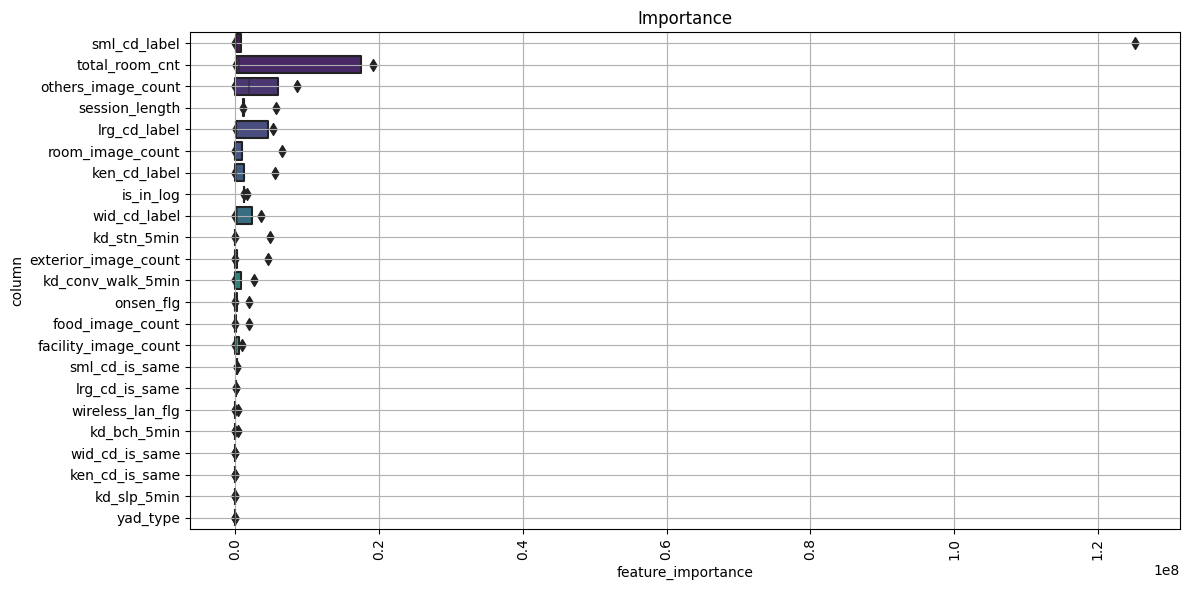

In [30]:
def visualize_importance(models, feat_train_df):
    """
    LightGBMのmodel配列のfeature_importanceをplotする
    CVごとのブレをboxen plot
    
    Args:
        models:
        feat_train_df:
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i+1
        
        feature_importance_df = pd.concat(
            [feature_importance_df, _df],
            axis=0,
            ignore_index=True,
        )
        
    order = feature_importance_df.groupby("column").sum()[["feature_importance"]].sort_values("feature_importance", ascending=False).index[:50]
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

## Infer

In [31]:
# k個のモデルの予測確率を生成 shape=(5, N_test)
pred_prob = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])

pred_prob = np.mean(pred_prob, axis=0)

In [32]:
pred_prob

array([0.00102873, 0.00104171, 0.01178918, ..., 0.01092164, 0.0071499 ,
       0.01543192])

### 予測値の確認

out of foldの予測確率の分布とtestへの予測確率の分布を見る

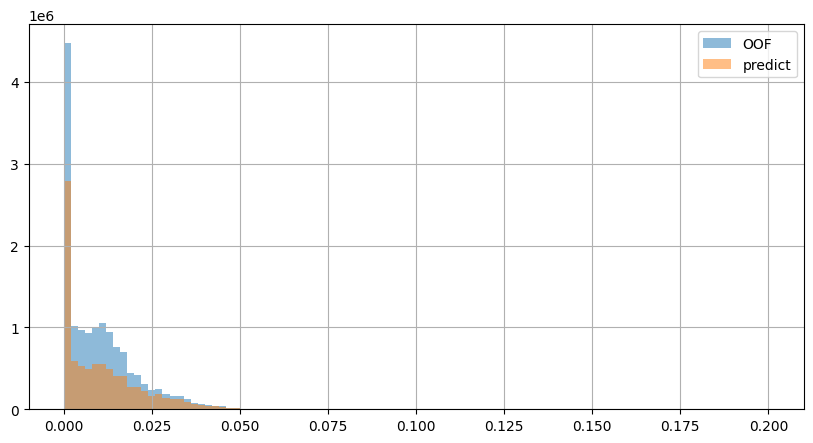

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.linspace(0, 0.2, 101)

ax.hist(oof, bins=bins, alpha=.5, label="OOF")
ax.hist(pred_prob, bins=bins, alpha=.5, label="predict")

ax.legend()
ax.grid()

In [34]:
submission = predict_top10_yad(predict=pred_prob, _df=test_df)
submission.columns = [f"predict_{c}" for c in submission.columns]
submission = submission.reset_index(drop=True)

In [35]:
submission.to_csv("submission.csv", index=False)

In [36]:
submission

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,930,6563,5785,11561,2680,6058,12834,10233,5466
1,11237,4066,6555,9523,6129,7018,4825,2494,3951,11923
2,757,1774,11001,6862,9910,3400,7710,2267,410,10485
3,12341,7049,10527,10535,6169,5771,3359,13022,11666,8527
4,9611,2355,11512,13235,1457,11910,6942,4275,12029,6126
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,1885,8771,12942,831,6282,11123,9543,7062
174696,1227,2232,9723,2491,3802,13702,6874,11739,4014,4962
174697,8468,7379,13719,844,2425,9196,11857,13782,8143,3929
174698,4606,3100,5515,1687,11496,3002,7080,2692,6358,2305
